In [4]:
import numpy as np
import pandas as pd
import yahoofinancials as yf
from yahoofinancials import YahooFinancials
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import time
from fuzzywuzzy import fuzz
import pickle
import random

plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras import optimizers
from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv('./temp_datalab_records_linkedin_company.csv')
all_comp_names = df['company_name'].unique()

In [6]:
service = ['Restaurants', 'Insurance', 'Financial Services', 'Media Production', 'Supermarkets',
           'Pharmaceuticals', 'Health, Wellness and Fitness', 'Airlines/Aviation', 'Banking','Investment Banking',
           'Construction', 'Facilities Services','Investment Management', 'Accounting', 'Retail', 
           'Consumer Services', 'Gambling & Casinos', ]
product = ['Consumer Electronics','Food Production','Utilities','Semiconductors',
            'Computer Networking','Medical Devices','Computer Games','Computer Software',
           'Sporting Goods', 'Glass, Ceramics & Concrete', 'Computer Hardware', 'Building Materials',
          'Furniture','Mining &amp; Metals',  'Luxury Goods & Jewelry', 'Wine and Spirits', 'Farming']

In [7]:
def price_per_wk(df_i, tbd):
    price_list = []
    for i in xrange(len(tbound)-1):
        mask_bd = (df_i['formatted_date'] >= tbd[i]) & (df_i['formatted_date'] < tbd[i+1])
        df_bin = df_i.loc[mask_bd]
        price_list.append(df_bin['close'].mean())
    return price_list

In [8]:
# https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    df.fillna(0, inplace=True)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
def split(values, n_in, n_train, n_valid):
    
    train = values[:n_train, :]
    valid = values[n_train:n_train+n_valid, :]
    test  = values[n_train+n_valid:, :]
    ftrain = values[:n_train+n_valid, :]

    train_X, train_y = train[:, :-1], train[:, -1]
    valid_X, valid_y = valid[:, :-1], valid[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    ftrain_X, ftrain_y = ftrain[:, :-1], ftrain[:, -1]

    # reshape input to be 3D [samples, timesteps=n_in, features=2]
    train_X = train_X.reshape((train_X.shape[0], n_in, 2))
    valid_X = valid_X.reshape((valid_X.shape[0], n_in, 2))
    test_X = test_X.reshape((test_X.shape[0], n_in, 2))
    ftrain_X = ftrain_X.reshape((ftrain_X.shape[0], n_in, 2))
    return [[train_X, valid_X, test_X, ftrain_X], [train_y, valid_y, test_y, ftrain_y]]

In [10]:
tmin, tmax = df['as_of_date'].min(), df['as_of_date'].max()
t, tbound = tmin, []
while t<tmax:
    tbound.append(t)
    t = pd.to_datetime(t) + pd.DateOffset(days=7)
    t = t.strftime('%Y-%m-%d')    

In [11]:
comp_emply = pickle.load( open( "comp_emply_dic.p", "rb" ) )
comp_tick = pickle.load( open( "comp_tick_dic.p", "rb" ) )

In [13]:
start_date = tbound[0]
end_date = tbound[-1]

In [14]:
stock_prices_dump = pickle.load( open( "stock_prices_dump.p", "rb" ) )

In [15]:
comp_prices = pickle.load( open( "comp_prices.p", "rb" ) )

In [16]:
final_names = []
data_set = {}
data_set0 = {}
for name, p in comp_prices.iteritems():
    emply = comp_emply[name][-80:]
    prices = comp_prices[name][-80:]
    if np.sum(np.isnan(emply)) == 0 and np.sum(np.isnan(prices)) == 0:
        final_names.append(name)
        X = np.array([prices, emply])
        X0= np.array([prices, [1.]*len(emply)])
        data_set[name] = X.transpose()
        data_set0[name] = X0.transpose()

print len(final_names)

1396


In [17]:
#pickle.dump([service_name, product_name], open( "serv_prod_name.p", "wb" ) )
service_name, product_name = pickle.load( open( "serv_prod_name.p", "rb" ) )
print len(service_name), len(product_name)

302 238


## Validation runs to tune hyperparameters (product)

In [19]:
#train with employment info
n_in = 5
n_train, n_valid = 50, 10
n_features = 2

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_in, n_features)))
model.add(Dropout(0.25))

model.add(LSTM(units=50))
model.add(Dropout(0.25))

model.add(Dense(1))
optm = optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optm)

(75, 11)
Instructions for updating:
Use tf.cast instead.
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 1s - loss: 0.2989 - val_loss: 0.1185
Epoch 2/2
 - 0s - loss: 0.2344 - val_loss: 0.0807
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0976 - val_loss: 0.0788
Epoch 2/2
 - 0s - loss: 0.0714 - val_loss: 0.0474
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0658 - val_loss: 0.1491
Epoch 2/2
 - 0s - loss: 0.0455 - val_loss: 0.0786
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0360 - val_loss: 0.0206
Epoch 2/2
 - 0s - loss: 0.0501 - val_loss: 0.0235
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0064 - val_loss: 0.0078
Epoch 2/2
 - 0s - loss: 0.0066 - val_loss: 0.0075
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0308 - val_loss: 0.1161
Epoch 2/2
 - 0s - loss: 0.0371 - val_loss: 0.1123
(75, 11)
Train on 50 samples, vali

(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0154 - val_loss: 0.0101
Epoch 2/2
 - 0s - loss: 0.0171 - val_loss: 0.0103
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0177 - val_loss: 0.0102
Epoch 2/2
 - 0s - loss: 0.0133 - val_loss: 0.0102
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0173 - val_loss: 0.0123
Epoch 2/2
 - 0s - loss: 0.0151 - val_loss: 0.0127
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0206 - val_loss: 0.0284
Epoch 2/2
 - 0s - loss: 0.0252 - val_loss: 0.0287
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0143 - val_loss: 0.1149
Epoch 2/2
 - 0s - loss: 0.0141 - val_loss: 0.1221
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0228 - val_loss: 0.0439
Epoch 2/2
 - 0s - loss: 0.0242 - val_loss: 0.0494
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.014

Epoch 2/2
 - 0s - loss: 0.0107 - val_loss: 0.0090
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0197 - val_loss: 0.0156
Epoch 2/2
 - 0s - loss: 0.0191 - val_loss: 0.0157
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0379 - val_loss: 0.0262
Epoch 2/2
 - 0s - loss: 0.0378 - val_loss: 0.0256
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0098 - val_loss: 0.0376
Epoch 2/2
 - 0s - loss: 0.0073 - val_loss: 0.0426
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0079 - val_loss: 0.0197
Epoch 2/2
 - 0s - loss: 0.0069 - val_loss: 0.0208
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0165 - val_loss: 0.0258
Epoch 2/2
 - 0s - loss: 0.0084 - val_loss: 0.0254
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0208 - val_loss: 0.0227
Epoch 2/2
 - 0s - loss: 0.0238 - val_loss: 0.0218
(75, 11)
Train on 50 samples, va

 - 0s - loss: 0.0198 - val_loss: 0.0354
Epoch 2/2
 - 0s - loss: 0.0187 - val_loss: 0.0347
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0122 - val_loss: 0.0032
Epoch 2/2
 - 0s - loss: 0.0110 - val_loss: 0.0041
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0131 - val_loss: 0.0135
Epoch 2/2
 - 0s - loss: 0.0156 - val_loss: 0.0139
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0112 - val_loss: 0.0088
Epoch 2/2
 - 0s - loss: 0.0106 - val_loss: 0.0065
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0078 - val_loss: 0.0070
Epoch 2/2
 - 0s - loss: 0.0086 - val_loss: 0.0080
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0108 - val_loss: 0.0250
Epoch 2/2
 - 0s - loss: 0.0093 - val_loss: 0.0226
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0153 - val_loss: 0.0368
Epoch 2/2
 - 0s - loss: 0.0203 - val_loss:

(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0076 - val_loss: 0.0085
Epoch 2/2
 - 0s - loss: 0.0082 - val_loss: 0.0083
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0108 - val_loss: 0.0064
Epoch 2/2
 - 0s - loss: 0.0085 - val_loss: 0.0062
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0148 - val_loss: 0.0064
Epoch 2/2
 - 0s - loss: 0.0137 - val_loss: 0.0054
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0084 - val_loss: 0.0045
Epoch 2/2
 - 0s - loss: 0.0052 - val_loss: 0.0045
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0203 - val_loss: 0.0048
Epoch 2/2
 - 0s - loss: 0.0166 - val_loss: 0.0072
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0094 - val_loss: 0.0311
Epoch 2/2
 - 0s - loss: 0.0134 - val_loss: 0.0293
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.007

Epoch 2/2
 - 0s - loss: 0.0081 - val_loss: 0.0039
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0036 - val_loss: 0.0057
Epoch 2/2
 - 0s - loss: 0.0032 - val_loss: 0.0055
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0169 - val_loss: 0.0350
Epoch 2/2
 - 0s - loss: 0.0165 - val_loss: 0.0304
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0197 - val_loss: 0.0044
Epoch 2/2
 - 0s - loss: 0.0124 - val_loss: 0.0053
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0188 - val_loss: 0.0208
Epoch 2/2
 - 0s - loss: 0.0190 - val_loss: 0.0213
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0098 - val_loss: 0.0099
Epoch 2/2
 - 0s - loss: 0.0108 - val_loss: 0.0099
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0027 - val_loss: 0.0047
Epoch 2/2
 - 0s - loss: 0.0044 - val_loss: 0.0053
(75, 11)
Train on 50 samples, va

 - 0s - loss: 0.0031 - val_loss: 0.0028
Epoch 2/2
 - 0s - loss: 0.0018 - val_loss: 0.0034
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0131 - val_loss: 0.0038
Epoch 2/2
 - 0s - loss: 0.0095 - val_loss: 0.0058
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0059 - val_loss: 0.0100
Epoch 2/2
 - 0s - loss: 0.0060 - val_loss: 0.0113
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0027 - val_loss: 0.0053
Epoch 2/2
 - 0s - loss: 0.0029 - val_loss: 0.0048
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0052 - val_loss: 0.0108
Epoch 2/2
 - 0s - loss: 0.0043 - val_loss: 0.0093
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0106 - val_loss: 0.0240
Epoch 2/2
 - 0s - loss: 0.0092 - val_loss: 0.0250
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0136 - val_loss: 0.0229
Epoch 2/2
 - 0s - loss: 0.0140 - val_loss:

(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0053 - val_loss: 7.5110e-04
Epoch 2/2
 - 0s - loss: 0.0050 - val_loss: 6.9401e-04
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0094 - val_loss: 0.0073
Epoch 2/2
 - 0s - loss: 0.0123 - val_loss: 0.0083
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0032 - val_loss: 9.3677e-04
Epoch 2/2
 - 0s - loss: 0.0034 - val_loss: 8.4300e-04
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0112 - val_loss: 0.0083
Epoch 2/2
 - 0s - loss: 0.0118 - val_loss: 0.0082
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0085 - val_loss: 0.0132
Epoch 2/2
 - 0s - loss: 0.0090 - val_loss: 0.0141
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0173 - val_loss: 0.0124
Epoch 2/2
 - 0s - loss: 0.0165 - val_loss: 0.0131
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 

Epoch 2/2
 - 0s - loss: 0.0136 - val_loss: 0.0098
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0091 - val_loss: 0.0029
Epoch 2/2
 - 0s - loss: 0.0073 - val_loss: 0.0052
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0099 - val_loss: 0.0133
Epoch 2/2
 - 0s - loss: 0.0102 - val_loss: 0.0147
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0063 - val_loss: 0.0032
Epoch 2/2
 - 0s - loss: 0.0056 - val_loss: 0.0027
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0135 - val_loss: 0.0115
Epoch 2/2
 - 0s - loss: 0.0100 - val_loss: 0.0135
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0033 - val_loss: 0.0119
Epoch 2/2
 - 0s - loss: 0.0045 - val_loss: 0.0120
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0112 - val_loss: 0.0085
Epoch 2/2
 - 0s - loss: 0.0078 - val_loss: 0.0057
(75, 11)
Train on 50 samples, va

 - 0s - loss: 0.0085 - val_loss: 0.0065
Epoch 2/2
 - 0s - loss: 0.0068 - val_loss: 0.0068
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0048 - val_loss: 0.0100
Epoch 2/2
 - 0s - loss: 0.0064 - val_loss: 0.0099
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0076 - val_loss: 0.0100
Epoch 2/2
 - 0s - loss: 0.0072 - val_loss: 0.0106
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0029 - val_loss: 0.0042
Epoch 2/2
 - 0s - loss: 0.0027 - val_loss: 0.0042
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0058 - val_loss: 0.0141
Epoch 2/2
 - 0s - loss: 0.0061 - val_loss: 0.0141
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0089 - val_loss: 0.0098
Epoch 2/2
 - 0s - loss: 0.0096 - val_loss: 0.0098
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0117 - val_loss: 0.0062
Epoch 2/2
 - 0s - loss: 0.0060 - val_loss:

(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0013 - val_loss: 0.0022
Epoch 2/2
 - 0s - loss: 8.1916e-04 - val_loss: 0.0022
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0016 - val_loss: 0.0022
Epoch 2/2
 - 0s - loss: 0.0015 - val_loss: 0.0022
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0016 - val_loss: 0.0073
Epoch 2/2
 - 0s - loss: 0.0021 - val_loss: 0.0074
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0039 - val_loss: 0.0070
Epoch 2/2
 - 0s - loss: 0.0044 - val_loss: 0.0071
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0096 - val_loss: 0.0106
Epoch 2/2
 - 0s - loss: 0.0107 - val_loss: 0.0109
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0028 - val_loss: 0.0033
Epoch 2/2
 - 0s - loss: 0.0032 - val_loss: 0.0033
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0

Epoch 2/2
 - 0s - loss: 0.0021 - val_loss: 0.0020
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0020 - val_loss: 0.0059
Epoch 2/2
 - 0s - loss: 0.0020 - val_loss: 0.0060
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0057 - val_loss: 0.0105
Epoch 2/2
 - 0s - loss: 0.0045 - val_loss: 0.0103
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0042 - val_loss: 0.0032
Epoch 2/2
 - 0s - loss: 0.0055 - val_loss: 0.0039
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0051 - val_loss: 0.0064
Epoch 2/2
 - 0s - loss: 0.0038 - val_loss: 0.0070
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0111 - val_loss: 0.0025
Epoch 2/2
 - 0s - loss: 0.0117 - val_loss: 0.0031
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0074 - val_loss: 0.0054
Epoch 2/2
 - 0s - loss: 0.0088 - val_loss: 0.0049
(75, 11)
Train on 50 samples, va

 - 0s - loss: 0.0068 - val_loss: 0.0099
Epoch 2/2
 - 0s - loss: 0.0054 - val_loss: 0.0102
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0025 - val_loss: 0.0044
Epoch 2/2
 - 0s - loss: 0.0024 - val_loss: 0.0045
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0081 - val_loss: 0.0125
Epoch 2/2
 - 0s - loss: 0.0105 - val_loss: 0.0124
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0062 - val_loss: 0.0043
Epoch 2/2
 - 0s - loss: 0.0052 - val_loss: 0.0041
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0045 - val_loss: 0.0222
Epoch 2/2
 - 0s - loss: 0.0041 - val_loss: 0.0224
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0026 - val_loss: 0.0040
Epoch 2/2
 - 0s - loss: 0.0031 - val_loss: 0.0041
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0061 - val_loss: 0.0066
Epoch 2/2
 - 0s - loss: 0.0073 - val_loss:

(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0020 - val_loss: 0.0111
Epoch 2/2
 - 0s - loss: 0.0024 - val_loss: 0.0110
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0016 - val_loss: 0.0035
Epoch 2/2
 - 0s - loss: 0.0019 - val_loss: 0.0036
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0018 - val_loss: 0.0042
Epoch 2/2
 - 0s - loss: 0.0024 - val_loss: 0.0042
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0025 - val_loss: 0.0016
Epoch 2/2
 - 0s - loss: 0.0021 - val_loss: 0.0019
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0012 - val_loss: 0.0041
Epoch 2/2
 - 0s - loss: 0.0013 - val_loss: 0.0041
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0060 - val_loss: 0.0131
Epoch 2/2
 - 0s - loss: 0.0065 - val_loss: 0.0127
(75, 11)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.004

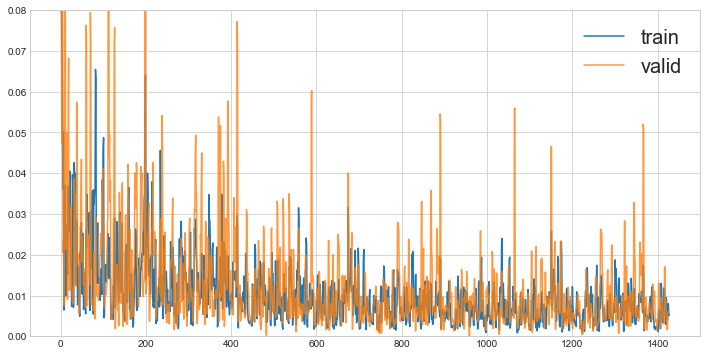

In [20]:
j = 1
scaler_dic = {}
all_history = {'loss':[], 'val_loss':[]}
n_epochs = 3
t0 = time.time()
for i in xrange(n_epochs):
  for name in product_name:
    values = data_set[name]
    train = values[:n_train, :]
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    _ = scaler.fit_transform(train)
    scaled = scaler.fit_transform(values)
    scaler_dic[name] = scaler
    
    res = series_to_supervised(scaled, n_in=n_in, n_out=1, dropnan=True)
    #drop the employment column since we are not predicting number of employees a company has
    res.drop(res.columns[[n_in*2+1]], axis=1, inplace=True)
    
    values = res.values
    print values.shape
    Xs, ys = split(values, n_in, n_train, n_valid)
    train_X, valid_X, test_X, ftrain_X = Xs
    train_y, valid_y, test_y, ftrain_y = ys

    # fit network
    history = model.fit(train_X, train_y, epochs=2, batch_size=30, validation_data=(valid_X, valid_y), verbose=2, shuffle=False)
    all_history['loss'] += history.history['loss']
    all_history['val_loss'] += history.history['val_loss']

print 'total train time: ', time.time()-t0, np.sum(all_history['val_loss'][-500:])
    
# plot all histories
plt.plot(all_history['loss'], label='train', alpha=1)
plt.plot(all_history['val_loss'], label='valid', alpha=0.8)
plt.ylim([0,.08])
plt.legend(fontsize=20)
plt.show()

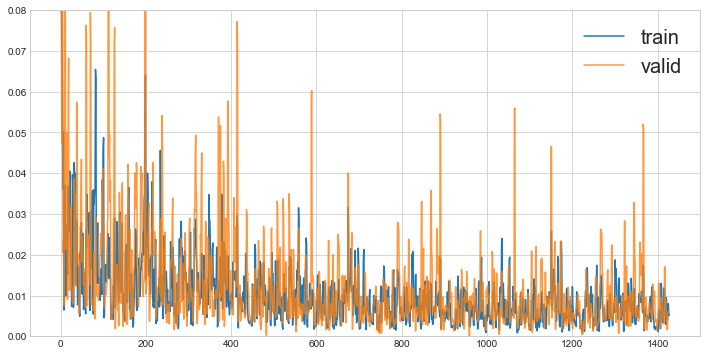

In [21]:
# plot all histories
plt.plot(all_history['loss'], label='train', alpha=1)
plt.plot(all_history['val_loss'], label='valid', alpha=0.8)
plt.ylim([0,.08])
plt.legend(fontsize=20)
plt.show()

## Fitting models and model comparison (product)

### Train model with employment info

In [22]:
#train with employment info
n_in = 5
n_train, n_valid = 50, 10
n_features = 2

model1 = Sequential()
model1.add(LSTM(50, return_sequences=True, input_shape=(n_in, n_features)))
model1.add(Dropout(0.25))

model1.add(LSTM(units=50))
model1.add(Dropout(0.25))

model1.add(Dense(1))
optm = optimizers.Adam(learning_rate=0.001)
model1.compile(loss='mean_squared_error', optimizer=optm)

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 1s 16ms/step - loss: 0.2927 - val_loss: 0.0473
Epoch 2/2
60/60 [==============================] - 0s 411us/step - loss: 0.2326 - val_loss: 0.0297
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 416us/step - loss: 0.1192 - val_loss: 0.0956
Epoch 2/2
60/60 [==============================] - 0s 476us/step - loss: 0.0877 - val_loss: 0.0553
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 445us/step - loss: 0.1040 - val_loss: 0.0980
Epoch 2/2
60/60 [==============================] - 0s 564us/step - loss: 0.0676 - val_loss: 0.0453
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 504us/step - loss: 0.0451 - val_loss: 0.0215
Epoch 2/2
60/60 [==============================] - 0s 886us/step - loss: 0.0572 - val_loss: 0.0263
Train on 60 samples, validate on 

Epoch 2/2
60/60 [==============================] - 0s 463us/step - loss: 0.0089 - val_loss: 0.0065
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 345us/step - loss: 0.0089 - val_loss: 0.0176
Epoch 2/2
60/60 [==============================] - 0s 383us/step - loss: 0.0108 - val_loss: 0.0164
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 446us/step - loss: 0.0390 - val_loss: 0.0097
Epoch 2/2
60/60 [==============================] - 0s 412us/step - loss: 0.0260 - val_loss: 0.0118
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 411us/step - loss: 0.0133 - val_loss: 0.0186
Epoch 2/2
60/60 [==============================] - 0s 398us/step - loss: 0.0182 - val_loss: 0.0207
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 385us/step - loss: 0.0162 - val_loss: 0.0200
Epoch 2/2
60/60 [===============

60/60 [==============================] - 0s 439us/step - loss: 0.0037 - val_loss: 0.0053
Epoch 2/2
60/60 [==============================] - 0s 404us/step - loss: 0.0041 - val_loss: 0.0048
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 446us/step - loss: 0.0132 - val_loss: 0.0071
Epoch 2/2
60/60 [==============================] - 0s 404us/step - loss: 0.0121 - val_loss: 0.0075
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 362us/step - loss: 0.0128 - val_loss: 0.0050
Epoch 2/2
60/60 [==============================] - 0s 405us/step - loss: 0.0145 - val_loss: 0.0053
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 388us/step - loss: 0.0055 - val_loss: 0.0206
Epoch 2/2
60/60 [==============================] - 0s 511us/step - loss: 0.0094 - val_loss: 0.0219
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 450us/step - loss: 0.0097 - val_loss: 0.0056
Epoch 2/2
60/60 [==============================] - 0s 439us/step - loss: 0.0128 - val_loss: 0.0056
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 379us/step - loss: 0.0114 - val_loss: 0.0170
Epoch 2/2
60/60 [==============================] - 0s 479us/step - loss: 0.0120 - val_loss: 0.0199
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 386us/step - loss: 0.0088 - val_loss: 0.0127
Epoch 2/2
60/60 [==============================] - 0s 449us/step - loss: 0.0088 - val_loss: 0.0094
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 405us/step - loss: 0.0146 - val_loss: 0.0099
Epoch 2/2
60/60 [==============================] - 0s 478us/step - loss: 0.0161 - val_loss: 0.0086
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 467us/step - loss: 0.0181 - val_loss: 0.0172
Epoch 2/2
60/60 [==============================] - 0s 474us/step - loss: 0.0206 - val_loss: 0.0179
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 405us/step - loss: 0.0207 - val_loss: 0.0086
Epoch 2/2
60/60 [==============================] - 0s 416us/step - loss: 0.0127 - val_loss: 0.0107
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 364us/step - loss: 0.0198 - val_loss: 0.0026
Epoch 2/2
60/60 [==============================] - 0s 420us/step - loss: 0.0218 - val_loss: 0.0029
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 487us/step - loss: 0.0117 - val_loss: 0.0122
Epoch 2/2
60/60 [==============================] - 0s 555us/step - loss: 0.0094 - val_loss: 0.0117
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 395us/step - loss: 0.0101 - val_loss: 0.0073
Epoch 2/2
60/60 [==============================] - 0s 465us/step - loss: 0.0115 - val_loss: 0.0082
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 578us/step - loss: 0.0185 - val_loss: 0.0093
Epoch 2/2
60/60 [==============================] - 0s 490us/step - loss: 0.0211 - val_loss: 0.0097
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 448us/step - loss: 0.0073 - val_loss: 0.0073
Epoch 2/2
60/60 [==============================] - 0s 493us/step - loss: 0.0097 - val_loss: 0.0100
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 488us/step - loss: 0.0141 - val_loss: 0.0227
Epoch 2/2
60/60 [==============================] - 0s 381us/step - loss: 0.0159 - val_loss: 0.0142
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 616us/step - loss: 0.0124 - val_loss: 0.0184
Epoch 2/2
60/60 [==============================] - 0s 500us/step - loss: 0.0091 - val_loss: 0.0189
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 411us/step - loss: 0.0039 - val_loss: 0.0158
Epoch 2/2
60/60 [==============================] - 0s 426us/step - loss: 0.0054 - val_loss: 0.0140
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 456us/step - loss: 0.0158 - val_loss: 0.0021
Epoch 2/2
60/60 [==============================] - 0s 397us/step - loss: 0.0096 - val_loss: 0.0023
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 485us/step - loss: 0.0064 - val_loss: 0.0176
Epoch 2/2
60/60 [==============================] - 0s 461us/step - loss: 0.0087 - val_loss: 0.0187
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 525us/step - loss: 0.0079 - val_loss: 0.0036
Epoch 2/2
60/60 [==============================] - 0s 478us/step - loss: 0.0087 - val_loss: 0.0034
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 551us/step - loss: 0.0029 - val_loss: 0.0068
Epoch 2/2
60/60 [==============================] - 0s 617us/step - loss: 0.0048 - val_loss: 0.0061
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 434us/step - loss: 0.0070 - val_loss: 0.0101
Epoch 2/2
60/60 [==============================] - 0s 503us/step - loss: 0.0090 - val_loss: 0.0102
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 495us/step - loss: 0.0060 - val_loss: 0.0054
Epoch 2/2
60/60 [==============================] - 0s 472us/step - loss: 0.0043 - val_loss: 0.0060
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 527us/step - loss: 0.0145 - val_loss: 0.0159
Epoch 2/2
60/60 [==============================] - 0s 547us/step - loss: 0.0110 - val_loss: 0.0158
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 516us/step - loss: 0.0168 - val_loss: 0.0078
Epoch 2/2
60/60 [==============================] - 0s 593us/step - loss: 0.0172 - val_loss: 0.0077
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 466us/step - loss: 0.0132 - val_loss: 0.0015
Epoch 2/2
60/60 [==============================] - 0s 445us/step - loss: 0.0159 - val_loss: 0.0015
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 405us/step - loss: 0.0093 - val_loss: 0.0165
Epoch 2/2
60/60 [==============================] - 0s 431us/step - loss: 0.0098 - val_loss: 0.0171
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 438us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 2/2
60/60 [==============================] - 0s 484us/step - loss: 0.0013 - val_loss: 0.0021
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 436us/step - loss: 0.0054 - val_loss: 0.0046
Epoch 2/2
60/60 [==============================] - 0s 432us/step - loss: 0.0058 - val_loss: 0.0049
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 430us/step - loss: 0.0072 - val_loss: 0.0032
Epoch 2/2
60/60 [==============================] - 0s 439us/step - loss: 0.0082 - val_loss: 0.0032
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 484us/step - loss: 0.0023 - val_loss: 0.0070
Epoch 2/2
60/60 [==============================] - 0s 399us/step - loss: 0.0016 - val_loss: 0.0070
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 461us/step - loss: 0.0071 - val_loss: 0.0027
Epoch 2/2
60/60 [==============================] - 0s 500us/step - loss: 0.0089 - val_loss: 0.0028
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 474us/step - loss: 0.0085 - val_loss: 0.0088
Epoch 2/2
60/60 [==============================] - 0s 475us/step - loss: 0.0088 - val_loss: 0.0078
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 679us/step - loss: 0.0053 - val_loss: 0.0043
Epoch 2/2
60/60 [==============================] - 0s 414us/step - loss: 0.0043 - val_loss: 0.0036
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 459us/step - loss: 0.0071 - val_loss: 0.0059
Epoch 2/2
60/60 [==============================] - 0s 432us/step - loss: 0.0086 - val_loss: 0.0060
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 443us/step - loss: 0.0112 - val_loss: 0.0116
Epoch 2/2
60/60 [==============================] - 0s 473us/step - loss: 0.0125 - val_loss: 0.0121
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 618us/step - loss: 0.0106 - val_loss: 0.0070
Epoch 2/2
60/60 [==============================] - 0s 509us/step - loss: 0.0116 - val_loss: 0.0071
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 404us/step - loss: 0.0125 - val_loss: 0.0042
Epoch 2/2
60/60 [==============================] - 0s 542us/step - loss: 0.0147 - val_loss: 0.0036
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 532us/step - loss: 0.0074 - val_loss: 0.0089
Epoch 2/2
60/60 [==============================] - 0s 493us/step - loss: 0.0071 - val_loss: 0.0089
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 498us/step - loss: 0.0062 - val_loss: 0.0046
Epoch 2/2
60/60 [==============================] - 0s 497us/step - loss: 0.0075 - val_loss: 0.0045
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 469us/step - loss: 0.0103 - val_loss: 0.0056
Epoch 2/2
60/60 [==============================] - 0s 611us/step - loss: 0.0131 - val_loss: 0.0061
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 481us/step - loss: 0.0055 - val_loss: 0.0038
Epoch 2/2
60/60 [==============================] - 0s 674us/step - loss: 0.0065 - val_loss: 0.0058
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 585us/step - loss: 0.0085 - val_loss: 0.0119
Epoch 2/2
60/60 [==============================] - 0s 492us/step - loss: 0.0087 - val_loss: 0.0100
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 535us/step - loss: 0.0085 - val_loss: 0.0121
Epoch 2/2
60/60 [==============================] - 0s 526us/step - loss: 0.0090 - val_loss: 0.0122
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 479us/step - loss: 0.0039 - val_loss: 0.0087
Epoch 2/2
60/60 [==============================] - 0s 608us/step - loss: 0.0036 - val_loss: 0.0086
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 484us/step - loss: 0.0073 - val_loss: 0.0014
Epoch 2/2
60/60 [==============================] - 0s 536us/step - loss: 0.0090 - val_loss: 0.0016
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 506us/step - loss: 0.0051 - val_loss: 0.0136
Epoch 2/2
60/60 [==============================] - 0s 724us/step - loss: 0.0063 - val_loss: 0.0139
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 430us/step - loss: 0.0052 - val_loss: 0.0040
Epoch 2/2
60/60 [==============================] - 0s 418us/step - loss: 0.0060 - val_loss: 0.0046
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 449us/step - loss: 0.0030 - val_loss: 0.0045
Epoch 2/2
60/60 [==============================] - 0s 435us/step - loss: 0.0028 - val_loss: 0.0046
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 382us/step - loss: 0.0108 - val_loss: 0.0093
Epoch 2/2
60/60 [==============================] - 0s 548us/step - loss: 0.0082 - val_loss: 0.0095
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 570us/step - loss: 0.0045 - val_loss: 0.0049
Epoch 2/2
60/60 [==============================] - 0s 505us/step - loss: 0.0060 - val_loss: 0.0043
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 485us/step - loss: 0.0085 - val_loss: 0.0143
Epoch 2/2
60/60 [==============================] - 0s 478us/step - loss: 0.0117 - val_loss: 0.0142
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 446us/step - loss: 0.0119 - val_loss: 0.0076
Epoch 2/2
60/60 [==============================] - 0s 521us/step - loss: 0.0146 - val_loss: 0.0080
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 548us/step - loss: 0.0119 - val_loss: 0.0017
Epoch 2/2
60/60 [==============================] - 0s 514us/step - loss: 0.0160 - val_loss: 0.0018
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 509us/step - loss: 0.0094 - val_loss: 0.0111
Epoch 2/2
60/60 [==============================] - 0s 594us/step - loss: 0.0096 - val_loss: 0.0124
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 490us/step - loss: 9.6717e-04 - val_loss: 0.0027
Epoch 2/2
60/60 [==============================] - 0s 517us/step - loss: 0.0015 - val_loss: 0.0024
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 779us/step - loss: 0.0039 - val_loss: 0.0044
Epoch 2/2
60/60 [==============================] - 0s 673us/step - loss: 0.0050 - val_loss: 0.0045
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 525us/step - loss: 0.0066 - val_loss: 0.0026
Epoch 2/2
60/60 [==============================] - 0s 498us/step - loss: 0.0053 - val_loss: 0.0026
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 760us/step - loss: 0.0021 - val_loss: 0.0077
Epoch 2/2
60/60 [==============================] - 0s 426us/step - loss: 0.0024 - val_loss: 0.0081
Train on 60 samples, validat

60/60 [==============================] - 0s 499us/step - loss: 0.0076 - val_loss: 0.0067
Epoch 2/2
60/60 [==============================] - 0s 494us/step - loss: 0.0111 - val_loss: 0.0069
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 553us/step - loss: 0.0108 - val_loss: 0.0130
Epoch 2/2
60/60 [==============================] - 0s 549us/step - loss: 0.0116 - val_loss: 0.0133
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 433us/step - loss: 0.0096 - val_loss: 0.0073
Epoch 2/2
60/60 [==============================] - 0s 558us/step - loss: 0.0091 - val_loss: 0.0075
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 428us/step - loss: 0.0140 - val_loss: 0.0038
Epoch 2/2
60/60 [==============================] - 0s 473us/step - loss: 0.0151 - val_loss: 0.0040
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 477us/step - loss: 0.0071 - val_loss: 0.0046
Epoch 2/2
60/60 [==============================] - 0s 488us/step - loss: 0.0092 - val_loss: 0.0047
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 438us/step - loss: 0.0064 - val_loss: 0.0044
Epoch 2/2
60/60 [==============================] - 0s 529us/step - loss: 0.0048 - val_loss: 0.0044
total train time:  58.7272109985


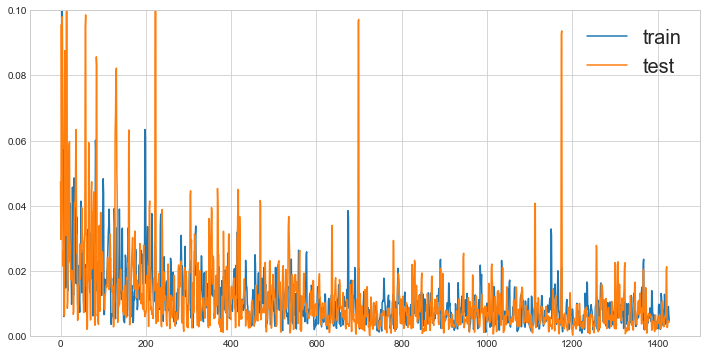

In [23]:
j = 1
scaler1_dic = {}
all_history1 = {'loss':[], 'val_loss':[]}
n_epochs = 3
t0 = time.time()
fnames = product_name
for i in xrange(n_epochs):
  #random.shuffle(fnames)
  for name in fnames:
    values = data_set[name]

    scaler1 = MinMaxScaler(feature_range=(0, 1))
    _ = scaler1.fit_transform(train)
    scaled = scaler1.fit_transform(values)
    scaler1_dic[name] = scaler1
    
    res = series_to_supervised(scaled, n_in=n_in, n_out=1, dropnan=True)
    #drop the employment column since we are not predicting number of employees a company has
    res.drop(res.columns[[n_in*2+1]], axis=1, inplace=True)
    
    values = res.values
    Xs, ys = split(values, n_in, n_train, n_valid)
    train_X, valid_X, test_X, ftrain_X = Xs
    train_y, valid_y, test_y, ftrain_y = ys

    j += 1

    # fit network
    history = model1.fit(ftrain_X, ftrain_y, epochs=2, batch_size=30, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    all_history1['loss'] += history.history['loss']
    all_history1['val_loss'] += history.history['val_loss']

print 'total train time: ', time.time()-t0
# plot all histories
plt.plot(all_history1['loss'], label='train1')
plt.plot(all_history1['val_loss'], label='test1')
plt.ylim([0,.1])
plt.legend(fontsize=20)
plt.show()

### Train without employment info (product)

In [31]:
#train with employment info
n_in = 5
n_train, n_valid = 50, 10
n_features = 2

model0 = Sequential()
model0.add(LSTM(50, return_sequences=True, input_shape=(n_in, n_features)))
model0.add(Dropout(0.25))

model0.add(LSTM(units=50))
model0.add(Dropout(0.250))

model0.add(Dense(1))
optm = optimizers.Adam(learning_rate=0.001)
model0.compile(loss='mean_squared_error', optimizer=optm)

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 1s 20ms/step - loss: 0.2402 - val_loss: 0.0642
Epoch 2/2
60/60 [==============================] - 0s 479us/step - loss: 0.1987 - val_loss: 0.0496
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 456us/step - loss: 0.0893 - val_loss: 0.1163
Epoch 2/2
60/60 [==============================] - 0s 458us/step - loss: 0.0663 - val_loss: 0.0767
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 441us/step - loss: 0.0832 - val_loss: 0.0952
Epoch 2/2
60/60 [==============================] - 0s 507us/step - loss: 0.0505 - val_loss: 0.0434
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 431us/step - loss: 0.0213 - val_loss: 0.0100
Epoch 2/2
60/60 [==============================] - 0s 527us/step - loss: 0.0307 - val_loss: 0.0131
Train on 60 samples, validate on 

Epoch 2/2
60/60 [==============================] - 0s 526us/step - loss: 0.0134 - val_loss: 0.0126
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 483us/step - loss: 0.0090 - val_loss: 0.0149
Epoch 2/2
60/60 [==============================] - 0s 481us/step - loss: 0.0093 - val_loss: 0.0161
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 454us/step - loss: 0.0302 - val_loss: 0.0089
Epoch 2/2
60/60 [==============================] - 0s 451us/step - loss: 0.0301 - val_loss: 0.0094
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 436us/step - loss: 0.0159 - val_loss: 0.0119
Epoch 2/2
60/60 [==============================] - 0s 498us/step - loss: 0.0151 - val_loss: 0.0116
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 430us/step - loss: 0.0124 - val_loss: 0.0150
Epoch 2/2
60/60 [===============

60/60 [==============================] - 0s 340us/step - loss: 0.0021 - val_loss: 0.0055
Epoch 2/2
60/60 [==============================] - 0s 454us/step - loss: 0.0025 - val_loss: 0.0041
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 456us/step - loss: 0.0110 - val_loss: 0.0061
Epoch 2/2
60/60 [==============================] - 0s 602us/step - loss: 0.0127 - val_loss: 0.0062
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 402us/step - loss: 0.0132 - val_loss: 0.0053
Epoch 2/2
60/60 [==============================] - 0s 477us/step - loss: 0.0130 - val_loss: 0.0050
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 477us/step - loss: 0.0039 - val_loss: 0.0089
Epoch 2/2
60/60 [==============================] - 0s 469us/step - loss: 0.0035 - val_loss: 0.0088
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 439us/step - loss: 0.0132 - val_loss: 0.0039
Epoch 2/2
60/60 [==============================] - 0s 484us/step - loss: 0.0118 - val_loss: 0.0047
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 438us/step - loss: 0.0112 - val_loss: 0.0133
Epoch 2/2
60/60 [==============================] - 0s 501us/step - loss: 0.0123 - val_loss: 0.0136
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 429us/step - loss: 0.0081 - val_loss: 0.0071
Epoch 2/2
60/60 [==============================] - 0s 514us/step - loss: 0.0050 - val_loss: 0.0057
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 426us/step - loss: 0.0095 - val_loss: 0.0078
Epoch 2/2
60/60 [==============================] - 0s 438us/step - loss: 0.0108 - val_loss: 0.0075
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 464us/step - loss: 0.0150 - val_loss: 0.0119
Epoch 2/2
60/60 [==============================] - 0s 492us/step - loss: 0.0162 - val_loss: 0.0125
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 414us/step - loss: 0.0107 - val_loss: 0.0092
Epoch 2/2
60/60 [==============================] - 0s 582us/step - loss: 0.0128 - val_loss: 0.0105
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 472us/step - loss: 0.0193 - val_loss: 0.0033
Epoch 2/2
60/60 [==============================] - 0s 492us/step - loss: 0.0145 - val_loss: 0.0028
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 502us/step - loss: 0.0105 - val_loss: 0.0126
Epoch 2/2
60/60 [==============================] - 0s 482us/step - loss: 0.0084 - val_loss: 0.0125
Train on 60 samples, validate on

60/60 [==============================] - 0s 489us/step - loss: 0.0204 - val_loss: 0.0042
Epoch 2/2
60/60 [==============================] - 0s 466us/step - loss: 0.0174 - val_loss: 0.0041
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 382us/step - loss: 0.0106 - val_loss: 0.0176
Epoch 2/2
60/60 [==============================] - 0s 465us/step - loss: 0.0105 - val_loss: 0.0176
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 392us/step - loss: 0.0055 - val_loss: 0.0127
Epoch 2/2
60/60 [==============================] - 0s 492us/step - loss: 0.0049 - val_loss: 0.0111
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 406us/step - loss: 0.0111 - val_loss: 0.0018
Epoch 2/2
60/60 [==============================] - 0s 426us/step - loss: 0.0093 - val_loss: 0.0018
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 556us/step - loss: 0.0109 - val_loss: 0.0070
Epoch 2/2
60/60 [==============================] - 0s 380us/step - loss: 0.0099 - val_loss: 0.0072
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 400us/step - loss: 0.0068 - val_loss: 0.0035
Epoch 2/2
60/60 [==============================] - 0s 531us/step - loss: 0.0071 - val_loss: 0.0038
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 389us/step - loss: 0.0030 - val_loss: 0.0056
Epoch 2/2
60/60 [==============================] - 0s 452us/step - loss: 0.0031 - val_loss: 0.0054
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 385us/step - loss: 0.0065 - val_loss: 0.0097
Epoch 2/2
60/60 [==============================] - 0s 552us/step - loss: 0.0094 - val_loss: 0.0098
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 492us/step - loss: 0.0128 - val_loss: 0.0045
Epoch 2/2
60/60 [==============================] - 0s 532us/step - loss: 0.0081 - val_loss: 0.0055
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 458us/step - loss: 0.0118 - val_loss: 0.0160
Epoch 2/2
60/60 [==============================] - 0s 442us/step - loss: 0.0122 - val_loss: 0.0156
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 451us/step - loss: 0.0162 - val_loss: 0.0079
Epoch 2/2
60/60 [==============================] - 0s 667us/step - loss: 0.0161 - val_loss: 0.0085
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 505us/step - loss: 0.0138 - val_loss: 0.0019
Epoch 2/2
60/60 [==============================] - 0s 499us/step - loss: 0.0152 - val_loss: 0.0020
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 485us/step - loss: 0.0046 - val_loss: 0.0048
Epoch 2/2
60/60 [==============================] - 0s 536us/step - loss: 0.0055 - val_loss: 0.0049
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 453us/step - loss: 0.0013 - val_loss: 0.0042
Epoch 2/2
60/60 [==============================] - 0s 520us/step - loss: 0.0012 - val_loss: 0.0037
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 493us/step - loss: 0.0052 - val_loss: 0.0054
Epoch 2/2
60/60 [==============================] - 0s 475us/step - loss: 0.0056 - val_loss: 0.0055
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 480us/step - loss: 0.0066 - val_loss: 0.0033
Epoch 2/2
60/60 [==============================] - ETA: 0s - loss: 0.009 - 0s 618us/step - loss: 0.0073 - val_loss: 0.0033
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 495us/step - loss: 0.0115 - val_loss: 0.0064
Epoch 2/2
60/60 [==============================] - 0s 553us/step - loss: 0.0138 - val_loss: 0.0064
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 336us/step - loss: 0.0069 - val_loss: 0.0029
Epoch 2/2
60/60 [==============================] - 0s 466us/step - loss: 0.0058 - val_loss: 0.0029
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 378us/step - loss: 0.0077 - val_loss: 0.0100
Epoch 2/2
60/60 [==============================] - 0s 485us/step - loss: 0.0078 - val_loss: 0.0103
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 395us/step - loss: 0.0042 - val_loss: 0.0083
Epoch 2/2
60/60 [==============================] - 0s 497us/step - loss: 0.0050 - val_loss: 0.0066
Train on 60 samples, validate on

Epoch 2/2
60/60 [==============================] - 0s 588us/step - loss: 0.0040 - val_loss: 0.0026
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 494us/step - loss: 0.0099 - val_loss: 0.0052
Epoch 2/2
60/60 [==============================] - 0s 519us/step - loss: 0.0095 - val_loss: 0.0054
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 475us/step - loss: 0.0059 - val_loss: 0.0050
Epoch 2/2
60/60 [==============================] - 0s 508us/step - loss: 0.0054 - val_loss: 0.0049
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 423us/step - loss: 0.0130 - val_loss: 0.0055
Epoch 2/2
60/60 [==============================] - 0s 531us/step - loss: 0.0090 - val_loss: 0.0057
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 446us/step - loss: 0.0058 - val_loss: 0.0034
Epoch 2/2
60/60 [===============

60/60 [==============================] - 0s 471us/step - loss: 0.0071 - val_loss: 0.0116
Epoch 2/2
60/60 [==============================] - 0s 499us/step - loss: 0.0084 - val_loss: 0.0120
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 440us/step - loss: 0.0082 - val_loss: 0.0063
Epoch 2/2
60/60 [==============================] - 0s 596us/step - loss: 0.0108 - val_loss: 0.0064
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 360us/step - loss: 0.0043 - val_loss: 0.0034
Epoch 2/2
60/60 [==============================] - 0s 620us/step - loss: 0.0037 - val_loss: 0.0035
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 449us/step - loss: 0.0022 - val_loss: 0.0064
Epoch 2/2
60/60 [==============================] - 0s 498us/step - loss: 0.0021 - val_loss: 0.0066
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 467us/step - loss: 0.0270 - val_loss: 0.0031
Epoch 2/2
60/60 [==============================] - 0s 536us/step - loss: 0.0294 - val_loss: 0.0037
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 437us/step - loss: 0.0079 - val_loss: 0.0033
Epoch 2/2
60/60 [==============================] - 0s 560us/step - loss: 0.0068 - val_loss: 0.0039
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 419us/step - loss: 0.0105 - val_loss: 0.0148
Epoch 2/2
60/60 [==============================] - 0s 507us/step - loss: 0.0104 - val_loss: 0.0147
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 727us/step - loss: 0.0168 - val_loss: 0.0081
Epoch 2/2
60/60 [==============================] - 0s 529us/step - loss: 0.0138 - val_loss: 0.0090
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 466us/step - loss: 0.0016 - val_loss: 0.0071
Epoch 2/2
60/60 [==============================] - 0s 500us/step - loss: 0.0018 - val_loss: 0.0071
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 481us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 2/2
60/60 [==============================] - 0s 416us/step - loss: 0.0034 - val_loss: 0.0042
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 506us/step - loss: 0.0012 - val_loss: 0.0039
Epoch 2/2
60/60 [==============================] - 0s 526us/step - loss: 0.0013 - val_loss: 0.0034
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 493us/step - loss: 0.0051 - val_loss: 0.0051
Epoch 2/2
60/60 [==============================] - 0s 433us/step - loss: 0.0060 - val_loss: 0.0055
Train on 60 samples, validate on

60/60 [==============================] - 0s 487us/step - loss: 0.0072 - val_loss: 0.0076
Epoch 2/2
60/60 [==============================] - 0s 557us/step - loss: 0.0046 - val_loss: 0.0078
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 384us/step - loss: 0.0051 - val_loss: 0.0098
Epoch 2/2
60/60 [==============================] - 0s 529us/step - loss: 0.0054 - val_loss: 0.0102
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 435us/step - loss: 0.0122 - val_loss: 0.0063
Epoch 2/2
60/60 [==============================] - 0s 528us/step - loss: 0.0137 - val_loss: 0.0064
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 397us/step - loss: 0.0114 - val_loss: 0.0111
Epoch 2/2
60/60 [==============================] - 0s 489us/step - loss: 0.0098 - val_loss: 0.0112
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 595us/step - loss: 0.0057 - val_loss: 0.0200
Epoch 2/2
60/60 [==============================] - 0s 497us/step - loss: 0.0103 - val_loss: 0.0194
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 456us/step - loss: 0.0042 - val_loss: 0.0024
Epoch 2/2
60/60 [==============================] - 0s 492us/step - loss: 0.0038 - val_loss: 0.0027
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 407us/step - loss: 0.0103 - val_loss: 0.0046
Epoch 2/2
60/60 [==============================] - 0s 551us/step - loss: 0.0075 - val_loss: 0.0047
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 484us/step - loss: 0.0063 - val_loss: 0.0046
Epoch 2/2
60/60 [==============================] - 0s 548us/step - loss: 0.0062 - val_loss: 0.0045
total train time:  60.6114230156


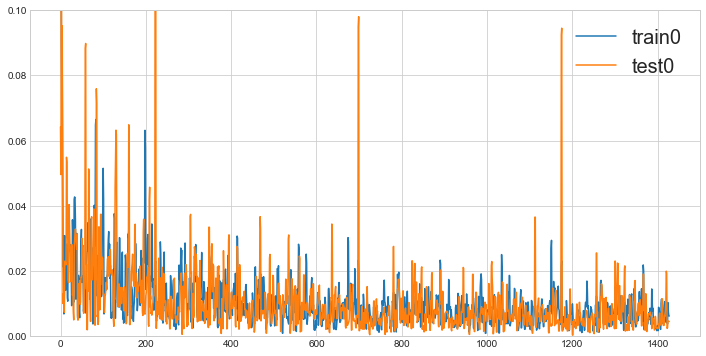

In [32]:
scaler0_dic = {}
all_history0 = {'loss':[], 'val_loss':[]}
n_epochs = 3
t0 = time.time()
fnames = product_name
for i in xrange(n_epochs):
  for name in fnames:
    values = data_set0[name]

    scaler0 = MinMaxScaler(feature_range=(0, 1))
    _ = scaler0.fit_transform(train)
    scaled = scaler0.fit_transform(values)
    scaler0_dic[name] = scaler0
    
    res = series_to_supervised(scaled, n_in=n_in, n_out=1, dropnan=True)
    res.drop(res.columns[[n_in*2+1]], axis=1, inplace=True)
    
    values = res.values
    Xs, ys = split(values, n_in, n_train, n_valid)
    train_X, valid_X, test_X, ftrain_X = Xs
    train_y, valid_y, test_y, ftrain_y = ys

    # fit network
    history = model0.fit(ftrain_X, ftrain_y, epochs=2, batch_size=30, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    all_history0['loss'] += history.history['loss']
    all_history0['val_loss'] += history.history['val_loss']

print 'total train time: ', time.time()-t0
# plot all histories
plt.plot(all_history0['loss'], label='train0')
plt.plot(all_history0['val_loss'], label='test0')
plt.ylim([0,.1])
plt.legend(fontsize=20)
plt.show()

In [34]:
# save the trained models
pickle.dump([model1,scaler1_dic, all_history1, model0, scaler0_dic, all_history0], open( "model1_model0_prod.p", "wb" ) )
model1,scaler1_dic, all_history1, model0, scaler0_dic, all_history0 = pickle.load( open( "model1_model0_prod.p", "rb" ) )

In [35]:
def predict_y(modelx, name, dataset, sc_dic, n_in, n_train, n_valid):
    
    values = dataset[name]
    sc = sc_dic[name]
    scaled = sc.transform(values)
    res = series_to_supervised(scaled, n_in=n_in, n_out=1, dropnan=True)
    res.drop(res.columns[[n_in*2+1]], axis=1, inplace=True)
    
    values = res.values
    Xs, ys = split(values, n_in, n_train, n_valid)
    train_X, valid_X, test_X, ftrain_X = Xs
    train_y, valid_y, test_y, ftrain_y = ys
    
    yhat = modelx.predict(test_X)
    inv_yhat = sc.inverse_transform( np.concatenate((yhat, yhat), axis=1) )[:,0]

    y = test_y.reshape((len(test_y),1))
    inv_y = sc.inverse_transform( np.concatenate((y, y), axis=1) )[:,0]
    
    return y, yhat, inv_y, inv_yhat
    

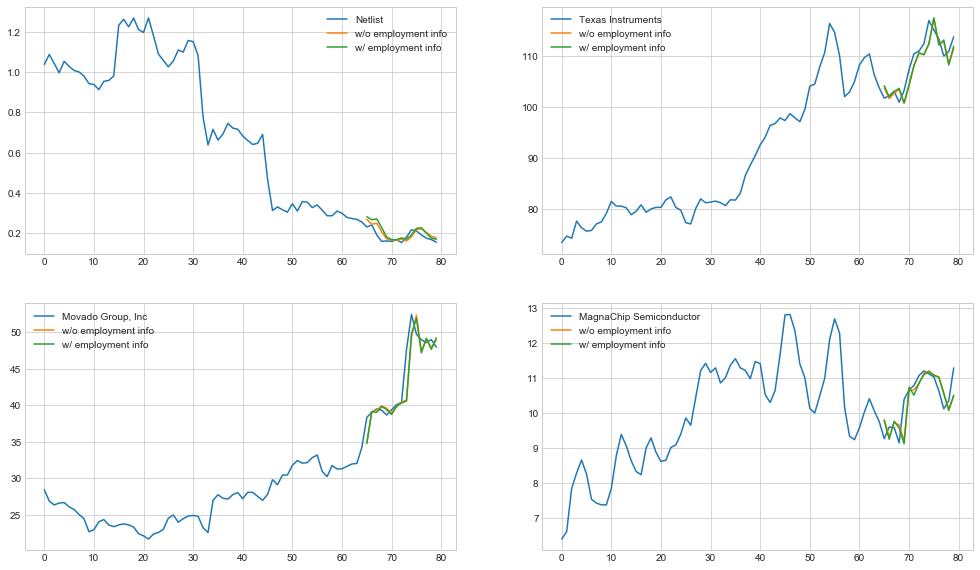

In [40]:
n_stock = 4
fnames = product_name[:]
random.shuffle(fnames)
fnames = fnames[:n_stock]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(17,10))
axs = axs.flatten()
for i, name in enumerate(fnames):
    y0, yhat0, inv_y0, inv_yhat0 = predict_y(model0, name, data_set0, scaler0_dic, n_in, n_train, n_valid)
    y1, yhat1, inv_y1, inv_yhat1 = predict_y(model1, name, data_set, scaler1_dic, n_in, n_train, n_valid)
    
    y = data_set[name][:,0]
    x = range(len(y))
    
    axs[i].plot(x, y, label=name)
    axs[i].plot(x[-len(inv_yhat0):], inv_yhat0, label = 'w/o employment info')
    axs[i].plot(x[-len(inv_yhat1):], inv_yhat1, label = 'w/ employment info')
    axs[i].legend()
    
plt.show()

In [37]:
# make a prediction
rms0, rms1 = [], []
for name in product_name:

    y0, yhat0, inv_y0, inv_yhat0 = predict_y(model0, name, data_set0, scaler0_dic, n_in, n_train, n_valid)
    y1, yhat1, inv_y1, inv_yhat1 = predict_y(model1, name, data_set, scaler1_dic, n_in, n_train, n_valid)
    
    rms0.append( np.sqrt(np.mean((y0-yhat0)**2)) )
    rms1.append( np.sqrt(np.mean((y1-yhat1)**2)) )

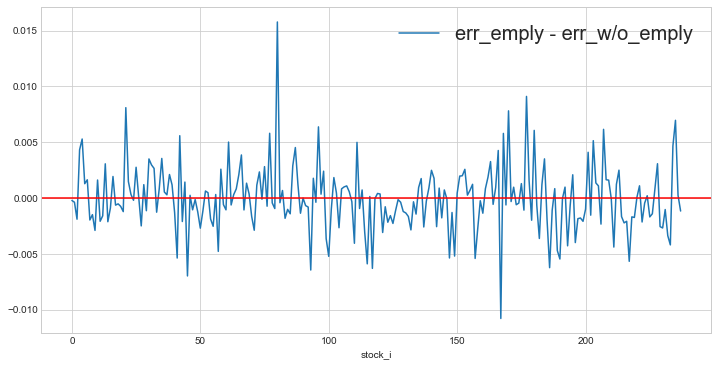

In [38]:
err_diff = [e1-e0 for e0,e1 in zip(rms0, rms1)]
plt.plot(err_diff, label='err_emply - err_w/o_emply')
plt.axhline(y=0., color='r', linestyle='-')
plt.xlabel('stock_i')
#plt.ylabel('rms_emply - rms_w/o_emply')
plt.legend(fontsize = 20)
plt.show()

### Take away:
1. Model fits better by split into industries, but still quite noisy.
2. No surprise: no prediction accuracy is gained by including employment history.
3. Next step: fit and check individual stocks.